<a href="https://colab.research.google.com/github/HagarIbrahiem/ML-Supervised-and-Unsupervised-Learning/blob/main/A_multi_input_model_%7CSiamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook will go through creating and training a `multi-input model`.

Building basic `Siamese Network` to find the similarity or dissimilarity between items of clothing.

## Import Libs

In [26]:
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Load Data

In [2]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

4422102/4422102 [==============================] - 0s 0us/step


## Utilis

Define utilities for preparing and visualizing dataset.

In [16]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1

    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]

    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):

    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')

    return pairs, y


def show_image(image):
    # plt.figure()
    plt.figure(figsize=(2,2))
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)

    plt.show()

**Create pairs of images that will go into the multi-input model**

In [12]:
# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

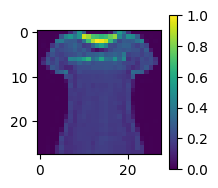

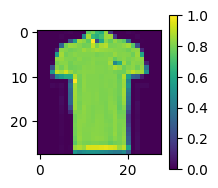

Similarity Score : 1.0


In [18]:
# array index
this_pair = 8

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print('Similarity Score :',ts_y[this_pair])

## Build Model

In [27]:
def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


# def euclidean_distance(vects):
#     x, y = vects
#     sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
#     return K.sqrt(K.maximum(sum_square, K.epsilon()))


# def eucl_dist_output_shape(shapes):
#     shape1, shape2 = shapes
#     return (shape1[0], 1)

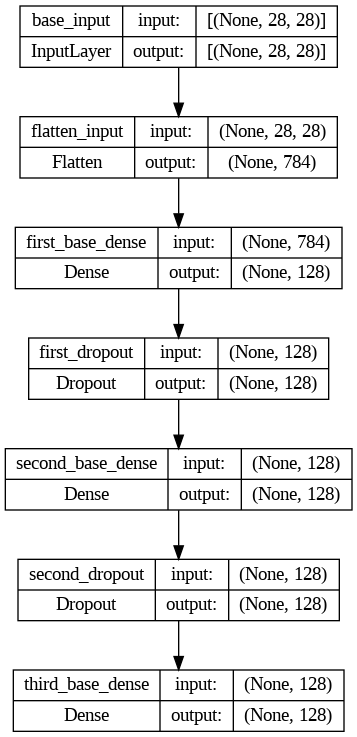

In [28]:
#Let's see how our base network looks.
#This is where the two inputs will pass through to generate an output vector.

base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

In [29]:
# following methods are used for the Custom Output Layer
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

Let's now build the Siamese network. The plot will show two inputs going to the base network.

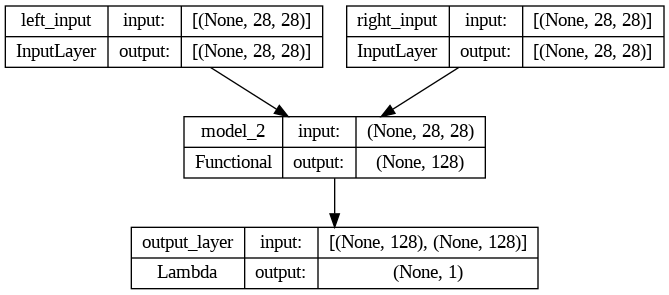

In [32]:
# create the left input and point to the base network
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

######

# measure the similarity of the two vector outputs
#Custom Output Layer
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

######

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

# Train Model

In [33]:
# Create Custom Loss Function

def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [34]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)

In [36]:
history = model.fit(  [tr_pairs[:,0], tr_pairs[:,1]],
                      tr_y,
                      epochs=10,
                      batch_size=128,
                      validation_data=([ts_pairs[:,0], ts_pairs[:,1]],
                      ts_y))

Epoch 1/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0891 - val_loss: 0.0819
Epoch 2/10
938/938 [==============================] - 10s 11ms/step - loss: 0.0772 - val_loss: 0.0776
Epoch 3/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0711 - val_loss: 0.0786
Epoch 4/10
938/938 [==============================] - 14s 15ms/step - loss: 0.0668 - val_loss: 0.0694
Epoch 5/10
938/938 [==============================] - 13s 14ms/step - loss: 0.0639 - val_loss: 0.0670
Epoch 6/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0621 - val_loss: 0.0668
Epoch 7/10
938/938 [==============================] - 14s 15ms/step - loss: 0.0605 - val_loss: 0.0668
Epoch 8/10
938/938 [==============================] - 12s 12ms/step - loss: 0.0590 - val_loss: 0.0662
Epoch 9/10
938/938 [==============================] - 15s 16ms/step - loss: 0.0577 - val_loss: 0.0662
Epoch 10/10
938/938 [==============================] - 13s 14ms/step - loss: 0.056

Evaluate Model

In [37]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [38]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 2ms/step
Loss = 0.06529785692691803, Train Accuracy = 0.9298716452742124 Test Accuracy = 0.9107107107107107


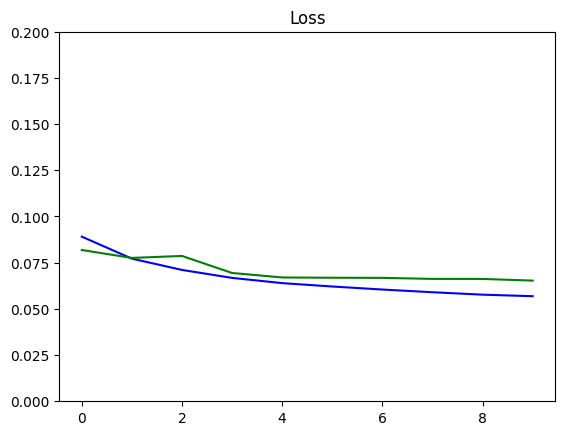

In [39]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [40]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)



sample results for 10 pairs of items

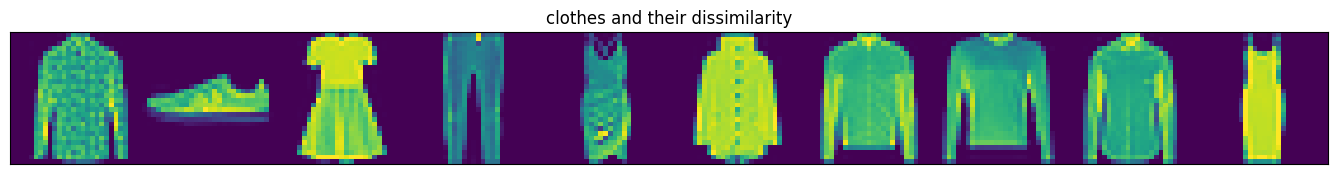

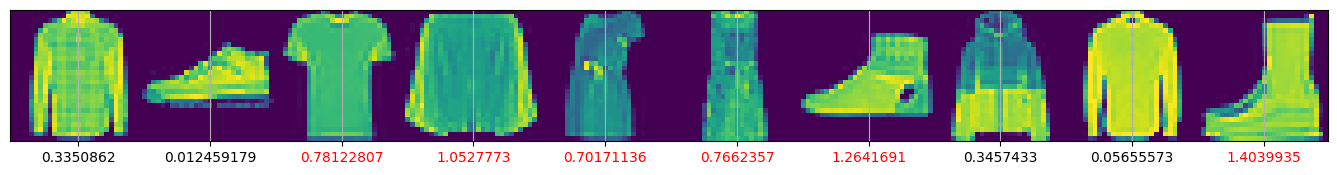

In [41]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)